# The MNIST Dataset

In this notebook, we will create a neural network to recognize handwritten digits from the famous MNIST dataset.

We will experiment with two different networks for this task. The first one will be a *multi-layer perceptron* (MLP), which is a standard type of feedforward neural network with fully-connected layers of weights, and the second will be a *convolutional neural network* (CNN), which takes advantage of the inherently two-dimensional spatial geometry of the input images.

Let's begin by reading in the MNIST dataset and printing a short description of its contents.

In [1]:
import conx as cx

Using TensorFlow backend.
ConX, version 3.7.4


In [2]:
mnist = cx.Dataset.get('mnist')
mnist.info()

**Dataset**: MNIST


Original source: http://yann.lecun.com/exdb/mnist/

The MNIST dataset contains 70,000 images of handwritten digits (zero
to nine) that have been size-normalized and centered in a square grid
of pixels.  Each image is a 28 × 28 × 1 array of floating-point numbers
representing grayscale intensities ranging from 0 (black) to 1
(white).  The target data consists of one-hot binary vectors of size
10, corresponding to the digit classification categories zero through
nine.  Some example MNIST images are shown below:

![MNIST Images](https://github.com/Calysto/conx/raw/master/data/mnist_images.png)

**Information**:
   * name    : MNIST
   * length  : 70000

**Input Summary**:
   * shape  : (28, 28, 1)
   * range  : (0.0, 1.0)

**Target Summary**:
   * shape  : (10,)
   * range  : (0.0, 1.0)



We can also print a shorter, less detailed summary:

In [3]:
mnist.summary()

_________________________________________________________________
MNIST:
Patterns    Shape                 Range                         
inputs      (28, 28, 1)           (0.0, 1.0)                    
targets     (10,)                 (0.0, 1.0)                    
Total patterns: 70000
   Training patterns: 70000
   Testing patterns: 0
_________________________________________________________________


Now let's take a look at some input patterns. Typing ``mnist.inputs[0]`` returns a large nested list of numbers, which isn't a particularly useful way to view a pattern.  A better way is to use ConX's ``view`` function:

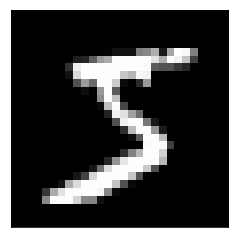

In [4]:
cx.view(mnist.inputs[0])

It's easy to view multiple patterns at once using Python's slice operator in conjunction with the ``layout`` keyword:

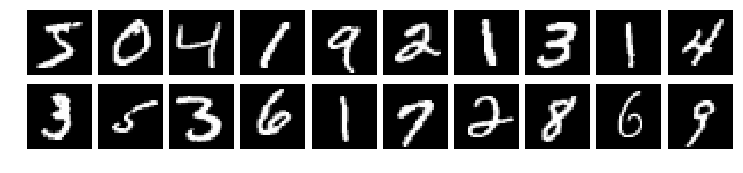

In [5]:
cx.view(mnist.inputs[0:20], layout=(2,10))

ConX allows us to refer to multiple input patterns using arbitrary indices:

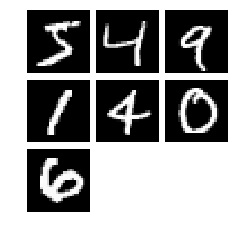

In [6]:
cx.view(mnist.inputs[0, 2, 4, 77, 150, 88, 9000])

Viewing the target patterns works in a similar way:

In [7]:
mnist.targets[0]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

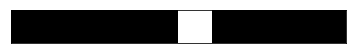

In [8]:
cx.view(mnist.targets[0])

In [9]:
mnist.targets[0:5]

[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

In addition to ``inputs`` and ``targets``, each dataset has a ``labels`` property that stores a collection of strings describing the classification category of each input:

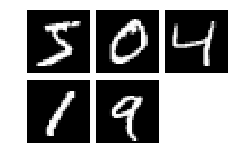

['5', '0', '4', '1', '9']


In [10]:
cx.view(mnist.inputs[0:5])
print(mnist.labels[0:5])

The ``labels`` property is useful for selecting particular input patterns. For example, to view just the "two"'s in the dataset, we can first create a list containing the index numbers of all of the "two"'s, and then view the first twenty, like this:

In [11]:
indices = [i for i in range(len(mnist.inputs)) if mnist.labels[i] == '2']
print('Found', len(indices), 'twos')
print(indices[:20])

Found 6990 twos
[5, 16, 25, 28, 76, 82, 109, 117, 120, 122, 143, 159, 161, 171, 178, 180, 187, 189, 190, 199]


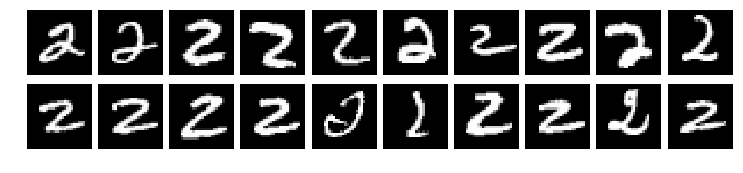

In [12]:
cx.view(mnist.inputs[indices[:20]], layout=(2,10))

We can accomplish the same thing more directly (and efficiently) using the `select` method, together with the `slice` keyword:

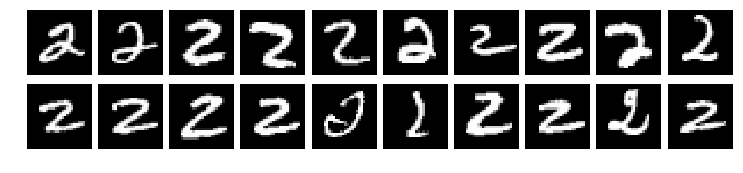

In [13]:
digits = mnist.inputs.select(lambda i,ds: ds.labels[i] == '2', slice=20)
cx.view(digits, layout=(2,10))

 Let's randomly shuffle the dataset before we train the network:

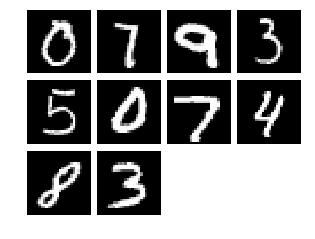

In [14]:
mnist.shuffle()
cx.view(mnist.inputs[0:10])

When training a neural network, it is usually best to divide the dataset into two subsets: the *training* set and the *testing* (or *validation*) set.  We train the network on the training patterns only, and test its performance on the validation set to see how well it handles novel patterns.  Calling ``split()`` returns a tuple containing the current sizes of the training and testing sets, respectively:

In [15]:
mnist.split()

(70000, 0)

We now split the data into 60,000 training patterns and 10,000 testing patterns, and then verify the split:

In [16]:
mnist.split(10000)
mnist.split()

(60000, 10000)

The last 10,000 patterns in the dataset are now reserved for testing.  As a convenience, we can refer to the training and testing sets independently, counting from 0, via the properties ``train_inputs``, ``train_targets``, ``train_labels``, and ``test_inputs``, ``test_targets``, and ``test_labels``.  The properties `inputs`, `targets`, and `labels` refer to all 70,000 input images, regardless of the current split.  For example:

In [17]:
print(len(mnist.inputs), 'total images')
print(len(mnist.train_inputs), 'images for training')
print(len(mnist.test_inputs), 'images for testing')

70000 total images
60000 images for training
10000 images for testing


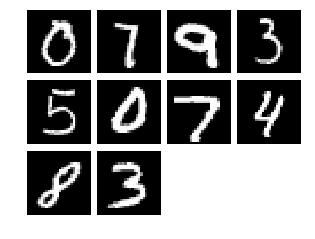

['0', '7', '9', '3', '5', '0', '7', '4', '8', '3']


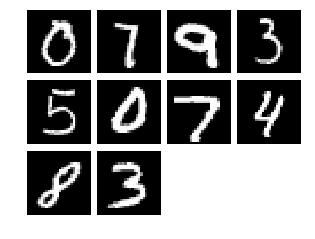

['0', '7', '9', '3', '5', '0', '7', '4', '8', '3']


In [18]:
cx.view(mnist.inputs[0:10])
print(mnist.labels[0:10])
cx.view(mnist.train_inputs[0:10])  # same as inputs[0:10]
print(mnist.train_labels[0:10])    # same as labels[0:10]

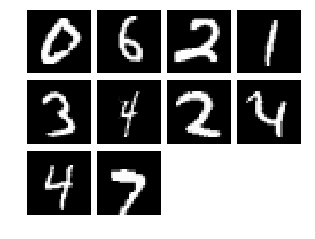

['0', '6', '2', '1', '3', '4', '2', '4', '4', '7']


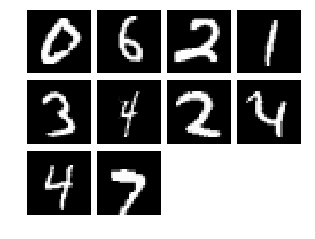

['0', '6', '2', '1', '3', '4', '2', '4', '4', '7']


In [19]:
cx.view(mnist.inputs[60000:60010])
print(mnist.labels[60000:60010])
cx.view(mnist.test_inputs[0:10])   # same as inputs[60000:60010]
print(mnist.test_labels[0:10])     # same as labels[60000:60010]

The MNIST digits are grayscale images, with each pixel represented as a single intensity value in the range 0 (black) to 1 (white). You can think of the whole image as consisting of 784 numbers arranged in a plane of 28 rows and 28 columns. For color (RGB) images, however, each pixel consists of three numbers (one for Red intensity, one for Green, and one for Blue). Therefore color images are represented as arrays of shape *rows* &times; *columns* &times; 3, where the 3 indicates the *depth* of the image. For consistency, the grayscale MNIST images are treated as images of depth 1, with shape *rows* &times; *columns* &times; 1. We can verify this by calling `cx.shape` on input image #0:

In [20]:
cx.shape(mnist.inputs[0])

(28, 28, 1)

## A multi-layer perceptron network for MNIST classification

Now we are ready to build a basic feedforward neural network to learn the MNIST data.  We will create a network with an input layer of shape 28 &times; 28 &times; 1, to match the shape of the input patterns, followed by two hidden layers of 30 units each, and an output classification layer.  However, in order to feed a 2-dimensional input image into the hidden layers, we must first "flatten" it into a linear vector of size 784 using a special ``FlattenLayer``.  Our output layer will have 10 units, one for each digit classification ("zero" to "nine"), and will use the *softmax* activation function.  A softmax layer outputs a *probability distribution*, which means that each of the numbers can be interpreted as a probability (in the range 0-1) representing the likelihood that the input pattern is an example of the corresponding classification category.  Here is a schematic picture of our network:

<p><img src="mnist_mlp_picture.png" width="50%"></p>

To build this network in ConX, we first create a ``Network`` object, giving it the arbitrary name "MNIST_MLP", then add each ``Layer`` in order.  Finally, we create the connections between layers using the single command ``connect()``.

In [21]:
net = cx.Network('MNIST_MLP')

net.add(cx.Layer('input', (28,28,1)))
net.add(cx.FlattenLayer('flat_input'))
net.add(cx.Layer('hidden1', 30, activation='relu'))
net.add(cx.Layer('hidden2', 30, activation='relu'))
net.add(cx.Layer('output', 10, activation='softmax'))

# creates connections between layers in the order they were added
net.connect()

In [22]:
net.picture()

We also need to tell the network which dataset to use:

In [23]:
net.set_dataset(mnist)

The final step after constructing the network is to compile it, specifying an *error* function (also called a "loss" function), and the learning algorithm to use (the *optimizer*).  For a classification task with the *softmax* activation function, it is usually best to choose the ``categorical_crossentropy`` error function.  For our learning algorithm, we will use standard Stochastic Gradient Descent.  We can also (optionally) specify the learning rate and momentum values to use.

In [24]:
net.compile(error='categorical_crossentropy', optimizer='SGD', lr=0.3, momentum=0.1)
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
flat_input (Flatten)         (None, 784)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 30)                23550     
_________________________________________________________________
hidden2 (Dense)              (None, 30)                930       
_________________________________________________________________
output (Dense)               (None, 10)                310       
Total params: 24,790
Trainable params: 24,790
Non-trainable params: 0
_________________________________________________________________


The network summary shows the details for each layer, along with the total number of network parameters.  The underlying Keras model on which the network is based is directly available via the ``model`` property, although normally the ConX user does not need to worry about the lower Keras level.

In [25]:
net.model

We can manually send an input pattern through the network using the ``propagate`` method.  For example, let's ask the network to classify input pattern #0:

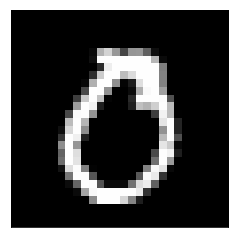

[0.0977730080485344,
 0.0672101154923439,
 0.08400549739599228,
 0.11776035279035568,
 0.10889045894145966,
 0.10750816762447357,
 0.0949573963880539,
 0.142753466963768,
 0.09871889650821686,
 0.08042261749505997]

In [26]:
cx.view(mnist.inputs[0])
net.propagate(mnist.inputs[0])

Not surprisingly, the output values for each classification category are all around 0.10 (representing 10% probability), because the network has not yet been trained.  After training, one of the output values will typically be much larger than the others, corresponding to the output classification category.

A more user-friendly way to view the behavior of the network is to open a ``dashboard`` so that we can see the activation of each layer more clearly.  The dashboard allows us to easily step through the input patterns (for either the training or testing set) and see the output of the network for each pattern, along with the correct target classification.  Clicking on **MNIST_MLP** at the top of the dashboard will open up a panel of settings for controlling the appearance and functionality of the network display. For example, to choose between the training set and testing set images, you can select "Train" or "Test" from the *Dataset* pulldown menu.

In [27]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

We can visualize the weights on connections into specific units by calling `plot_layer_weights`. For example, the command below shows the weights from the input layer into units 0, 1, and 2 of the first hidden layer, displayed as 28 &times; 28 pixel array (where each pixel represents a weight from the input layer into a hidden unit). The `wrange` keyword specifies the minimum and maximum weight values for the color coding. Since the network has not yet been trained, the weights are all small random values close to zero.

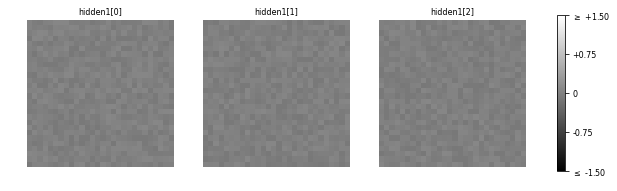

In [28]:
net.plot_layer_weights('hidden1', units=[0,1,2], vshape=(28,28), wrange=(-1.5, 1.5))

Let's train the network for 30 epochs, using a default batch size of 32. This means that images from the training set will be presented to the network in batches of 32 at a time, and for each batch, the SGD algorithm will update the network's weights by an appropriate amount. Then another batch of 32 images will be presented, and so on, until all 60,000 training images in the dataset have been processed, which constitutes one epoch of training. This entire cycle will be repeated for 30 epochs. As training proceeds, the network's error (loss) on both the training and testing/validation sets will be shown on the left graph, and the accuracy on each of these sets will be shown on the right graph. The accuracy is simply the fraction of input images that the network classifies correctly.  A classification is considered correct if the largest output value on the output layer corresponds to the target classification.

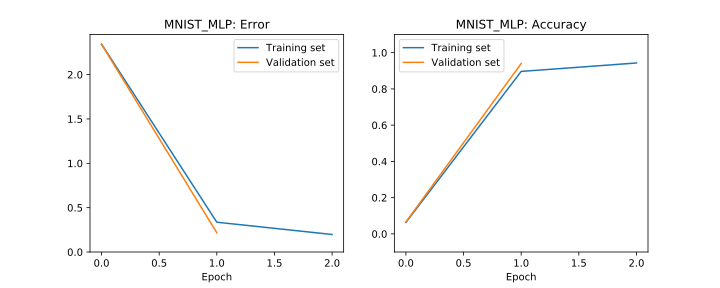

Interrupted! Cleaning up...
       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#    2 |   0.19710 |   0.94321 


KeyboardInterrupt: 

In [29]:
net.train(epochs=30)

The detailed epoch-by-epoch training history of the network is available by calling `show_results()`. The optional `report_rate` keyword specifies which epochs to show.

In [30]:
net.show_results(report_rate=5)

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#    0 |   2.34410 |   0.06307 |   2.34118 |   0.06570 
#    2 |   0.19710 |   0.94321 


The `plot` method shows the value of various network metrics during training. The metrics `loss` and `val_loss` represent the value of the error (loss) function on the training and testing sets, respectively.  Likewise, `acc` and `val_acc` represent the accuracy of the training and testing sets, respectively. The optional `ymin` and `ymax` keywords can be used to adjust the y-axis scale. For example:

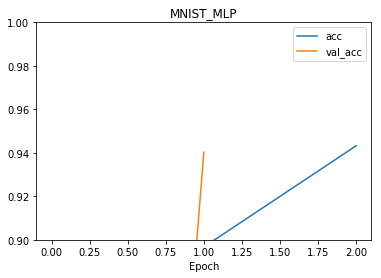

In [31]:
net.plot(['acc', 'val_acc'], ymin=0.9, ymax=1)

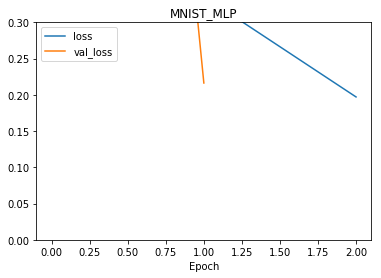

In [32]:
net.plot(['loss', 'val_loss'], ymin=0, ymax=0.3)

After training, the index of the largest output value in response to an input image corresponds to the network's digit classification.  To see this more clearly, we will make use of ConX's ``argmax`` function, which takes a list of numbers and returns the *position* of the largest number in the list (counting from 0).  For example, test input #42 is shown below, along with the network's response.

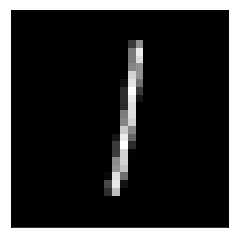

In [33]:
cx.view(net.dataset.test_inputs[42])

In [34]:
net.propagate(net.dataset.test_inputs[42])

[5.2092713303864e-05,
 0.9586198329925537,
 0.0066554853692650795,
 0.000483944546431303,
 0.01734444499015808,
 0.0013681561686098576,
 0.0008948856266215444,
 0.00332481786608696,
 0.006120710633695126,
 0.005135755520313978]

In [35]:
cx.argmax(net.propagate(net.dataset.test_inputs[42]))

1

Examining the weights into the same three hidden units as before shows that these units have learned to respond in different ways to different parts of the input image.

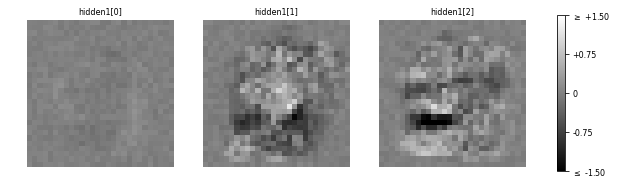

In [36]:
net.plot_layer_weights('hidden1', units=[0,1,2], vshape=(28,28), wrange=(-1.5, 1.5))

## A Convolutional Network for MNIST Classification

Convolutional neural networks (CNNs) are loosely inspired by the neurobiology of the visual system. The key idea is that each unit in a convolutional layer receives connections from a limited number of units in the previous layer (which can be thought of as the unit's "visual field"), and these connections are arranged in a two-dimensional topology to take advantage of spatial information. Each convolutional layer specifies a number of independent *features* to be learned, along with the *N*&nbsp;&times;&nbsp;*N* size of the visual field (also called the *kernel size*). The units responsible for learning a feature share connections across the entire convolutional layer, which often leads to far fewer network parameters compared to a network with fully-connected layers.

Another type of layer common to CNNs is the *pooling* layer, which reduces the amount of information flowing through the network by the process of subsampling. Each pooling unit receives input from a limited number of units in the previous layer, and then applies some function (like *maximum* or *average*) to these inputs. The overall effect is to produce a coarser-grained version of the information from the previous layer, which makes the network less sensitive to small variations in position.

We will define a CNN for MNIST classification using two convolutional layers with 5 &times; 5 kernels, each followed by a pooling layer with 2 &times; 2 kernels that compute the maximum of their inputs. The first convolutional layer will learn 16 relatively low-level features, whereas the second will learn 32 higher-level features. These features will then feed into a hidden layer (after being flattened), followed by an output classification layer using *softmax*.

In [36]:
import conx as cx

In [37]:
cnn = cx.Network("MNIST_CNN")

cnn.add(cx.Layer("input", (28,28,1), colormap="gray"),
        cx.Conv2DLayer("conv2D_1", 16, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool1", (2,2)),
        cx.Conv2DLayer("conv2D_2", 32, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool2", (2,2)),
        cx.FlattenLayer("flat"),
        cx.Layer("hidden", 30, activation='relu'),
        cx.Layer("output", 10, activation='softmax'))

cnn.connect()

Notice that each convolution layer in the network includes a `dropout` setting of 20%. Dropout is a technique that helps to improve a network's ability to generalize what it has learned, by making it less sensitive to noise and to irrelevant correlations that may exist in the training data.  During training, a randomly chosen subset of units in a dropout layer (here, 20% of the units) will be turned off (set to zero activation) on each training cycle, with different random subsets being chosen on each cycle. Dropout only occurs during training; after the network has learned, all units participate in the classification of input data. 

Next, we need to initialize our dataset and then compile the network.

In [38]:
cnn.get_dataset("MNIST")

In [39]:
cnn.dataset.split(10000)
cnn.dataset.summary()

_________________________________________________________________
MNIST:
Patterns    Shape                 Range                         
inputs      (28, 28, 1)           (0.0, 1.0)                    
targets     (10,)                 (0.0, 1.0)                    
Total patterns: 70000
   Training patterns: 60000
   Testing patterns: 10000
_________________________________________________________________


This time we will try the RMSprop algorithm, which automatically adjusts the learning rate and momentum as training proceeds.

In [40]:
cnn.compile(error='categorical_crossentropy', optimizer='RMSprop')

In [41]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 12, 12, 16)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 4, 4, 32)          0         
__________

<img src="mnist-cnn.png" width="80%">

In [42]:
cnn.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

Training our CNN on the full dataset will take a long time, so in the interest of brevity, let's reduce the size of our dataset by 80% using the ``chop`` method, which deletes the specified fraction of data from the dataset.

In [8]:
print('Starting with', len(cnn.dataset), 'patterns')
cnn.dataset.chop(0.80)
print(len(cnn.dataset), 'patterns left after chop')

Starting with 70000 patterns
14000 patterns left after chop


We then reserve 25% of the remaining data for testing.

In [43]:
cnn.dataset.split(0.25)
cnn.dataset.split()

(10500, 3500)

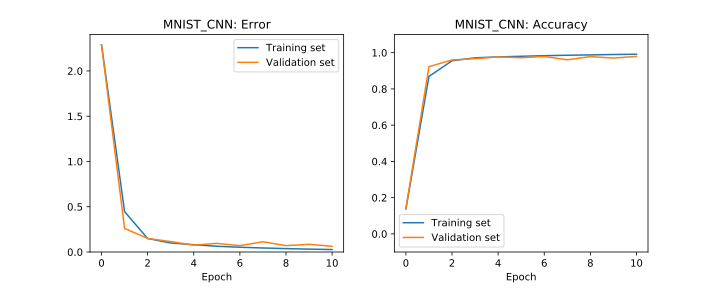

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   10 |   0.02725 |   0.99133 |   0.06282 |   0.97943 


In [44]:
cnn.reset()
cnn.train(epochs=10)

Now let's take a look at which test inputs the network got wrong.

In [45]:
results = [cnn.propagate(img) for img in cnn.dataset.test_inputs]
classifications = [cx.argmax(r) for r in results]
correct_answers = [cx.argmax(t) for t in cnn.dataset.test_targets]

In [46]:
wrong = [i for i in range(len(classifications)) if classifications[i] != correct_answers[i]]

In [47]:
print('Network classified the following', len(wrong), 'test inputs incorrectly:')
print(wrong)

Network classified the following 72 test inputs incorrectly:
[144, 216, 236, 256, 300, 324, 352, 364, 384, 444, 492, 530, 539, 604, 710, 804, 842, 938, 982, 1010, 1034, 1139, 1205, 1259, 1267, 1281, 1302, 1385, 1449, 1578, 1683, 1684, 1706, 1754, 1777, 1797, 1805, 1872, 2059, 2085, 2103, 2151, 2155, 2179, 2292, 2305, 2332, 2436, 2470, 2512, 2518, 2521, 2556, 2582, 2627, 2636, 2649, 2684, 2685, 2687, 2871, 2876, 2928, 2952, 3008, 3177, 3238, 3354, 3396, 3422, 3469, 3470]


Let's take a look at some of the incorrect classifications.  For clarity, we will label each of the misclassified images with the network's (wrong) answer.

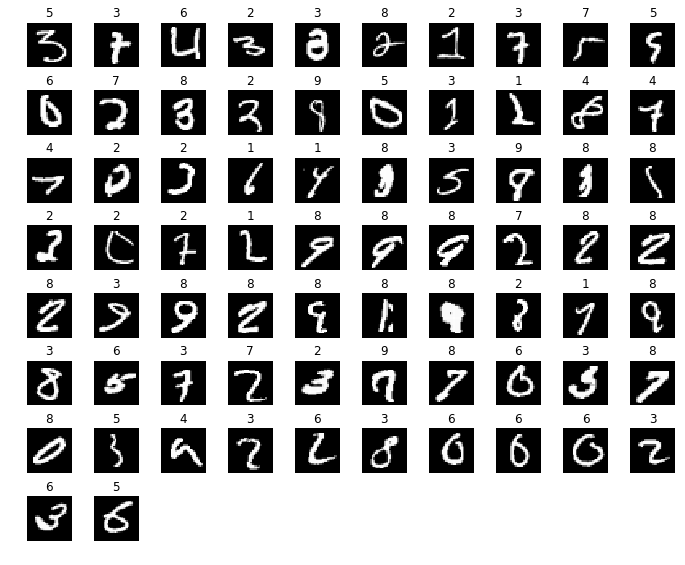

In [48]:
misclassifications = [classifications[i] for i in wrong]
cx.view(cnn.dataset.test_inputs[wrong], labels=misclassifications, layout=(None,10), spacing=0.5)